In [4]:
import pandas as pd
import os
import pytz

In [5]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [8]:
# 파일 불러오기
notop_one_df = pd.read_parquet("/content/drive/MyDrive/data/noTop3_one_time_buyers_all_events.parquet")
notop_multi_df = pd.read_parquet("/content/drive/MyDrive/data/noTop3_multi_buyers_all_events.parquet")

### 카테고리 3 결측치 처리

In [9]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
notop_one_df['category_lvl3'] = notop_one_df['category_lvl3'].fillna(notop_one_df['category_lvl2'])
notop_multi_df['category_lvl3'] = notop_multi_df['category_lvl3'].fillna(notop_multi_df['category_lvl2'])

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 1회 vs 다회 구매자 - 구매 건수 상위 카테고리 2 비교


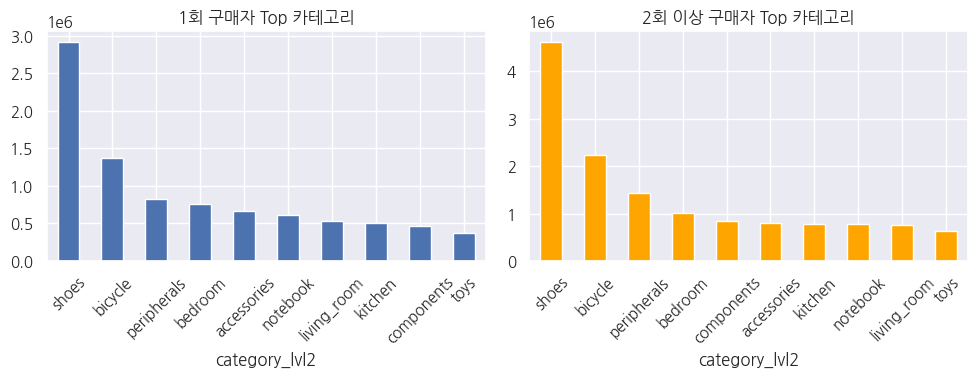

In [11]:
# 상위 카테고리 비교 (category_lvl2 기준)
top_n = 10
one_top_cat = notop_one_df['category_lvl2'].value_counts().head(top_n)
multi_top_cat = notop_multi_df['category_lvl2'].value_counts().head(top_n)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
one_top_cat.plot(kind='bar', title="1회 구매자 Top 카테고리")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
multi_top_cat.plot(kind='bar', title="2회 이상 구매자 Top 카테고리", color='orange')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

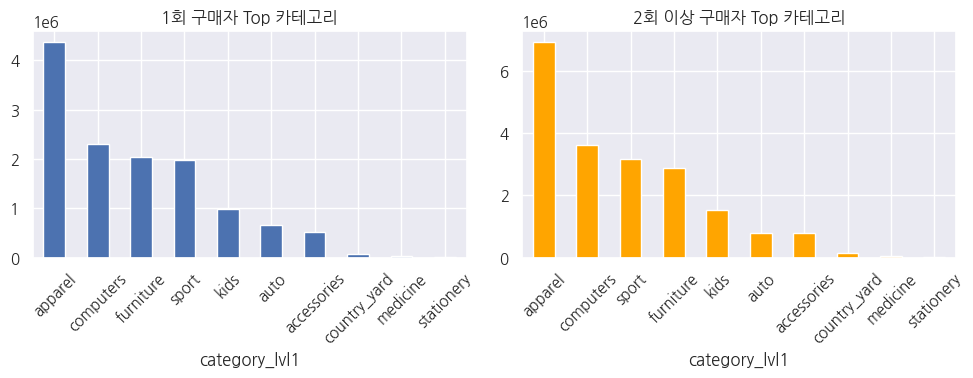

In [18]:
# 상위 카테고리 비교 (category_lvl2 기준)
top_n = 10
one_top_cat = notop_one_df['category_lvl1'].value_counts().head(top_n)
multi_top_cat = notop_multi_df['category_lvl1'].value_counts().head(top_n)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
one_top_cat.plot(kind='bar', title="1회 구매자 Top 카테고리")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
multi_top_cat.plot(kind='bar', title="2회 이상 구매자 Top 카테고리", color='orange')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# notop_multi_df에서 특정 category_lvl2 재구매율 확인
multi_product_counts = notop_multi_df.groupby(['user_id', 'category_lvl2']).size().reset_index(name='count')
repeats = multi_product_counts[multi_product_counts['count'] > 1]

# 반복 구매율 높은 상품 TOP 10
top_repeat_products = repeats['category_lvl2'].value_counts().head(10)
print("재구매율 높은 상품:", top_repeat_products)

재구매율 높은 상품: category_lvl2
shoes          138168
bicycle         95852
peripherals     59154
bedroom         57649
kitchen         46818
accessories     46548
toys            42486
living_room     41240
components      39071
bag             38133
Name: count, dtype: int64


# 2회 이상 구매자의 첫->두 번째 구매에서 카테고리 변경 비율, 경로

In [13]:
# 구매 이벤트만 필터링
multi_purchase = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].copy()

# 날짜 정렬
multi_purchase['event_date'] = pd.to_datetime(multi_purchase['event_date'])
multi_purchase = multi_purchase.sort_values(by=['user_id', 'event_date'])

# 유저별 구매 순서 부여
multi_purchase['purchase_order'] = multi_purchase.groupby('user_id').cumcount() + 1

# 첫 번째, 두 번째 구매만 추출
first_second = multi_purchase[multi_purchase['purchase_order'] <= 2]

# 첫/두 번째 구매를 하나의 행에 피벗
pivoted = first_second.pivot(index='user_id', columns='purchase_order', values='category_lvl1')
pivoted.columns = ['first_cat1', 'second_cat1']
pivoted = pivoted.dropna()

# 변경 여부 판단
pivoted['category_changed'] = pivoted['first_cat1'] != pivoted['second_cat1']

# 통계 요약
change_rate = pivoted['category_changed'].mean()
change_counts = pivoted['category_changed'].value_counts()

print("2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율:", round(change_rate, 3))
print("\n상세 분포:")
print(change_counts)

2회 이상 구매자의 첫→두번째 구매에서 카테고리 변경 비율: 0.313

상세 분포:
category_changed
False    141218
True      64282
Name: count, dtype: int64


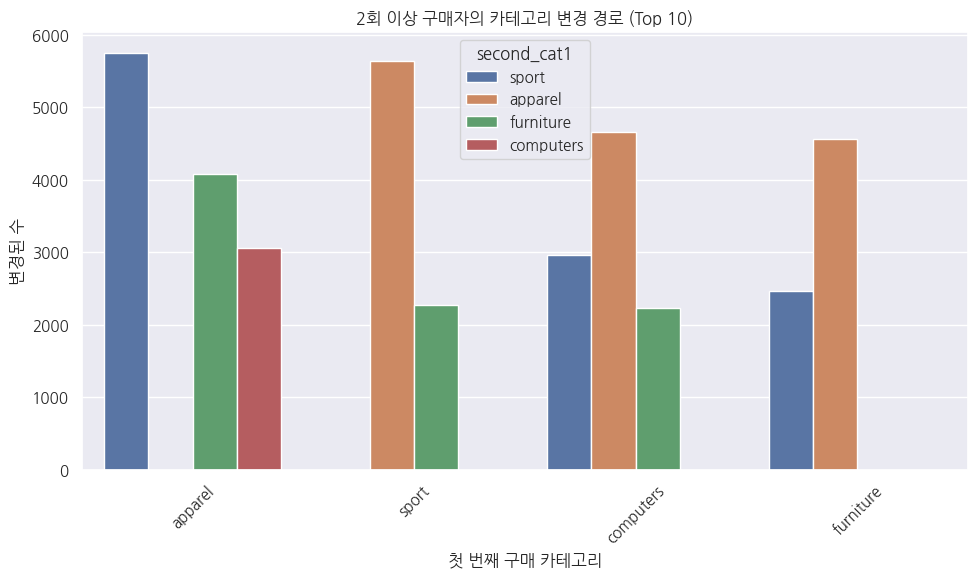

In [14]:
# 변경된 경우만 추출
changed_cases = pivoted[pivoted['category_changed']]

# 변화 경로 집계
change_paths = changed_cases.groupby(['first_cat1', 'second_cat1']).size().reset_index(name='count')
change_paths = change_paths.sort_values('count', ascending=False)

# 상위 몇 개만 시각화
top_paths = change_paths.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_paths, y='count', x='first_cat1', hue='second_cat1')
plt.title('2회 이상 구매자의 카테고리 변경 경로 (Top 10)')
plt.xlabel('첫 번째 구매 카테고리')
plt.ylabel('변경된 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2회 이상 구매자의 카테고리 조합

In [15]:
# 1. 구매 이벤트 필터링
multi_purchase = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 2. category_lvl2 → category_lvl1 매핑 테이블 생성
lvl2_lvl1_map = multi_purchase[['category_lvl2', 'category_lvl1']].drop_duplicates()

# 3. 유저별 구매한 category_lvl2 조합 생성
cat_combo = multi_purchase.groupby('user_id')['category_lvl2'].apply(lambda x: tuple(sorted(set(x))))
cat_combo = cat_combo.value_counts().head(10).reset_index()
cat_combo.columns = ['category_combination', 'user_count']

# 4. 각 조합에 포함된 category_lvl1 정보 추가
def map_to_lvl1(combo):
    lvl1_set = lvl2_lvl1_map[lvl2_lvl1_map['category_lvl2'].isin(combo)]['category_lvl1'].unique()
    return ', '.join(sorted(set(lvl1_set)))

cat_combo['category_lvl1'] = cat_combo['category_combination'].apply(map_to_lvl1)

print(cat_combo)

  category_combination  user_count       category_lvl1
0             (shoes,)       25276             apparel
1           (bicycle,)       25128               sport
2     (bicycle, shoes)        8341      apparel, sport
3       (peripherals,)        5621           computers
4           (bedroom,)        5507           furniture
5       (accessories,)        4179                auto
6          (notebook,)        3984           computers
7        (components,)        2608           computers
8           (kitchen,)        2561           furniture
9     (bedroom, shoes)        2338  apparel, furniture


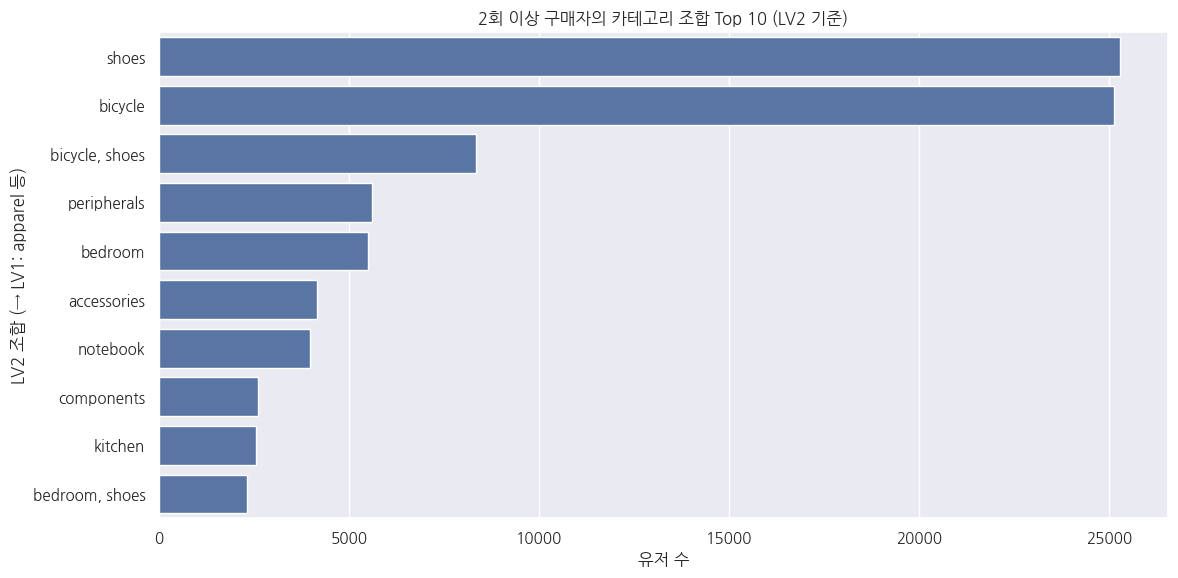

,category_combination,user_count,category_lvl1
0,shoes,25276,apparel
1,bicycle,25128,sport
2,"bicycle, shoes",8341,"apparel, sport"
3,peripherals,5621,computers
4,bedroom,5507,furniture
5,accessories,4179,auto
6,notebook,3984,computers
7,components,2608,computers
8,kitchen,2561,furniture
9,"bedroom, shoes",2338,"apparel, furniture"


In [16]:
# 5. 튜플을 문자열로 변환 (시각화를 위해)
cat_combo['category_combination'] = cat_combo['category_combination'].apply(lambda x: ', '.join(x))

# 6. 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_combo, y='category_combination', x='user_count')
plt.title('2회 이상 구매자의 카테고리 조합 Top 10 (LV2 기준)')
plt.xlabel('유저 수')
plt.ylabel('LV2 조합 (→ LV1: ' + cat_combo['category_lvl1'].iloc[0] + ' 등)')
plt.tight_layout()
plt.show()

# 결과 확인
display(cat_combo[['category_combination', 'user_count', 'category_lvl1']])

- apparel, sport, furniture 조합이 상위권 → 라이프스타일 연관 구매 경향

- 특정 카테고리 조합이 자주 반복되는 경우 → 추천 시스템, 번들 마케팅에 반영 가능

# 재구매율 낮은 카테고리 2

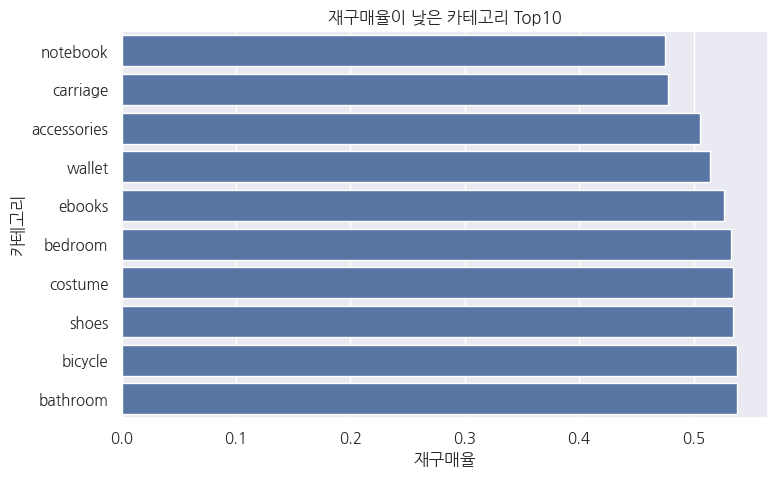

In [17]:
# 전체 유저 대비 재구매 유저 비율
total_users = notop_one_df[notop_one_df['event_type'] == 'purchase'].groupby('category_lvl2')['user_id'].nunique()
repeat_users = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].groupby('category_lvl2')['user_id'].nunique()

repurchase_rate = (repeat_users / (total_users + repeat_users)).reset_index()
repurchase_rate.columns = ['category_lvl2', 'repurchase_rate']

# 하위 10개 카테고리 시각화
bottom_10 = repurchase_rate.sort_values(by='repurchase_rate').head(10)

plt.figure(figsize=(8,5))
sns.barplot(data=bottom_10, x='repurchase_rate', y='category_lvl2')
plt.title('재구매율이 낮은 카테고리 Top10')
plt.xlabel('재구매율')
plt.ylabel('카테고리')
plt.tight_layout()
plt.show()